In [1]:
import numpy as np
import pandas as pd
import os

import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Dense, Flatten
from keras.optimizers import Adam
from keras import regularizers
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import random

# (1) Read in and explore the data

In [2]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

In [3]:
os.listdir(train_dir)

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

There are 7 categories in this dataset. Let's have a look to see how each class is distributed.

In [4]:
label_counts = {}
for emotion in os.listdir(train_dir):
    directory = train_dir + '/' + emotion
    label_counts[emotion] = len(os.listdir(directory))
label_counts = pd.DataFrame(label_counts, index=['train'])

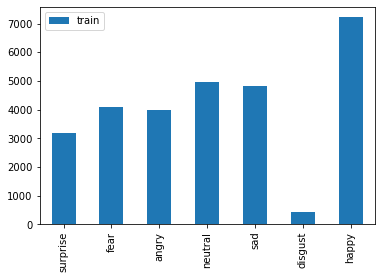

In [5]:
label_counts.transpose().plot(kind='bar')

There is a clear imbalance in the dataset, particularly in the 'disgust' class. I will remove 'disgust' from the dataset and work with the 6 remaining classes instead. I'll create a list of the classes I want to use and pass this as parameter to flow_from_directory(), essentially removing 'disgust' from the model.

In [6]:
used_classes = ['surprise', 'fear','angry','neutral','sad','happy']

Let's have a look at some images from each class to get a better understanding of the data.

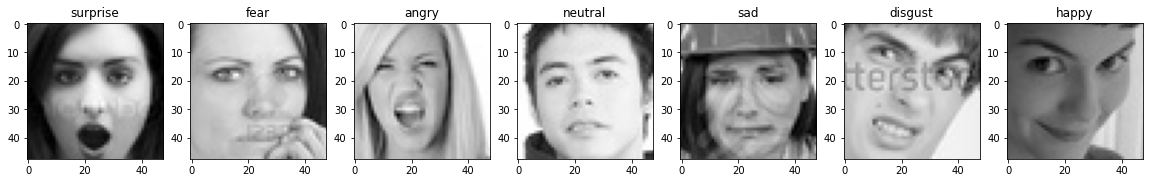

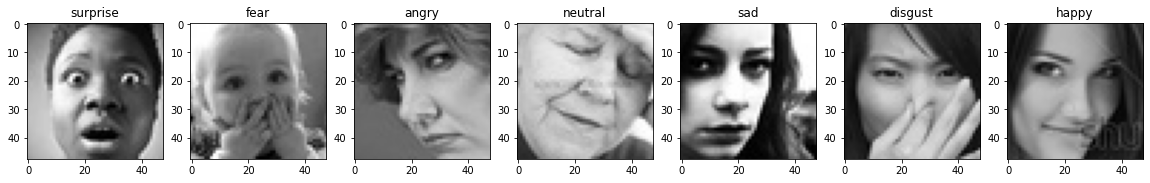

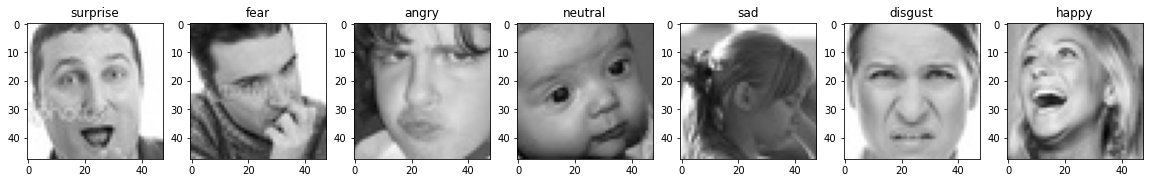

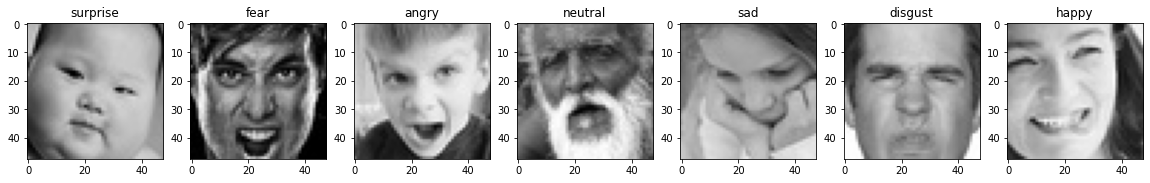

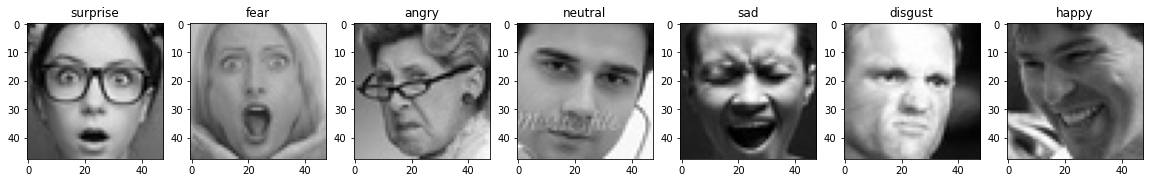

In [7]:
for pic in range(7,12):
  plt.figure(figsize=(20,20))
  i = 1
  for emotion in os.listdir(train_dir):
      img = load_img((train_dir + emotion +'/'+ os.listdir(train_dir + '/'+ emotion)[pic]))
      plt.subplot(1,7,i)
      plt.imshow(img)
      plt.title(emotion)
      i += 1
  plt.show()

Human accuracy was evaluated at 65(+/-)5% according to research published by the University of Montreal, https://arxiv.org/pdf/1307.0414.pdf. A quick glance at this dataset illustrates why performance on this dataset is relatively low. Even from the small sample displayed above there is some clearly questionable labels. For example, look at the 2nd row, 4th column image. Is this really a neutral expression? I think most would classify this a sad.  

# (2) Data preparation 

As the data is stored as jpg images in a directory structure, we can use tools from keras.preprocessing to efficiently read in the data in batches and preprocess at the same time. Some data augmentation(random rotations, horizontal flips, zoom) is applied to the training set, while both sets are scaled to pixel values between 0 and 1.

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.15,
    rotation_range=20,
    horizontal_flip=True,
    
)
train_images = train_datagen.flow_from_directory(
  train_dir,
  classes     = used_classes,
  color_mode  = 'grayscale',
  target_size = (48, 48),
  batch_size  = 64,
  class_mode  = 'categorical',
  shuffle     = True
)


test_datagen = ImageDataGenerator(rescale = 1./255)
test_images = test_datagen.flow_from_directory(
  test_dir,
  classes     = used_classes,
  color_mode  = 'grayscale',
  target_size = (48, 48),
  batch_size  = 64,
  class_mode  = 'categorical',
  shuffle     = False
)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


As we can see, disgust has been removed from our training/test datasets.

# (3) Build and evaluate the model

A combination of Conv2D, BatchNormalization, MaxPooling and Dropout layers are used in the convolutional base. Dense and dropout layers are used in the head. The base and head are combined to form a sequential model.

In [9]:
model = tf.keras.models.Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same', input_shape=(48,48,1)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='Same',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='Same',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))


model.compile(
  optimizer = Adam(lr=0.0001 , decay=1e-6), 
  loss='categorical_crossentropy', 
  metrics=['accuracy']
)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0

In [11]:
# Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
steps_per_epoch  = train_images.n // train_images.batch_size
validation_steps = test_images.n // test_images.batch_size

Define callback functions.

In [12]:
# Set up a checkpoint callback to  save model/weights in a checkpoint file. This will save the best model which we can load for later use.
checkpoint_filepath = 'checkpoints_ED.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_best_only=True,  # save only the best model
    monitor='val_loss',   # best model based off lowest val loss
    mode='min'            # as we want to save models with minimal loss
)

# We will use the ReduceLROnPlateau function to reduce the learning rate when val_loss has stopped improving.
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,       # factor by which the learning rate will be reduced
    patience=8,       # number of epochs with no improvement after which learning rate will be reduced.
    min_delta=0.001   # threshold for measuring the new optimum
)  


# Finally I will add an early stopping callback function to stop training when val_loss has stopped improving.
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
    min_delta=0.001, 
    patience=8, 
    verbose=1, 
    restore_best_weights=True
)

callbacks = [model_checkpoint_callback, reduce_lr_callback, early_stop_callback]

Fit the model.

In [13]:
history = model.fit(x = train_images,
                    validation_data = test_images,
                    epochs = 50,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    callbacks = callbacks)

Epoch 1/50
441/441 [==============================] - 173s 393ms/step - loss: 5.6402 - accuracy: 0.2642 - val_loss: 5.5189 - val_accuracy: 0.1800
Epoch 2/50
441/441 [==============================] - 39s 88ms/step - loss: 4.6079 - accuracy: 0.3297 - val_loss: 4.0714 - val_accuracy: 0.3845
Epoch 3/50
441/441 [==============================] - 40s 91ms/step - loss: 3.7672 - accuracy: 0.3771 - val_loss: 3.3208 - val_accuracy: 0.4362
Epoch 4/50
441/441 [==============================] - 40s 91ms/step - loss: 3.1280 - accuracy: 0.4069 - val_loss: 2.8253 - val_accuracy: 0.4453
Epoch 5/50
441/441 [==============================] - 39s 89ms/step - loss: 2.6624 - accuracy: 0.4375 - val_loss: 2.4010 - val_accuracy: 0.4810
Epoch 6/50
441/441 [==============================] - 40s 90ms/step - loss: 2.3198 - accuracy: 0.4591 - val_loss: 2.1090 - val_accuracy: 0.4942
Epoch 7/50
441/441 [==============================] - 40s 90ms/step - loss: 2.0634 - accuracy: 0.4838 - val_loss: 1.8961 - val_accurac

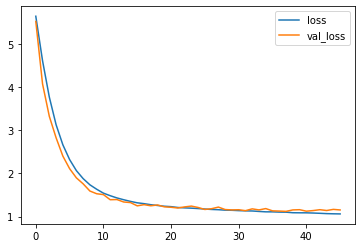

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

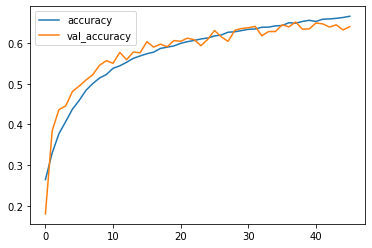

In [15]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();

Load the best model from the checkpoints file.

In [16]:
best_model = load_model('./checkpoints_ED.h5')

In [17]:
test_loss, test_acc = best_model.evaluate(test_images)
print('Accuracy on test data: {:.2f}%'.format(test_acc*100))
print('Loss on test data: {:.2f}'.format(test_loss))

111/111 [==============================] - 5s 46ms/step - loss: 1.1167 - accuracy: 0.6528
Accuracy on test data: 65.28%
Loss on test data: 1.12


# (4) Summary of results

Let's start by obtaining a list of the models predictions and the true labels for each test image.

In [18]:
model_predictions = best_model.predict(test_images)
model_predictions = np.argmax(model_predictions, axis=1)

true_predictions = test_images.classes

In [19]:
correct = np.equal(true_predictions,model_predictions)
print('Prediction accuracy: {:.2f}%'.format(np.sum(correct)/len(correct)*100))

Prediction accuracy: 65.28%


Have a look at the confusion matrix to see what classes our model struggled the most with. A look at the distribution of test images shows a reasonable balance of classes except for happy which has significantly more than the rest. Remember we have removed disgust images from our model.

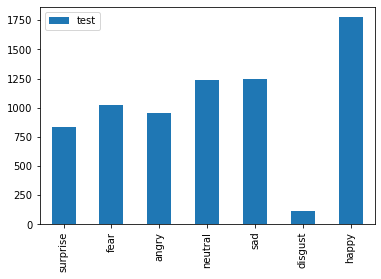

In [20]:
test_counts = {}
for emotion in os.listdir(test_dir):
    directory = test_dir + '/' + emotion
    test_counts[emotion] = len(os.listdir(directory))
test_counts = pd.DataFrame(test_counts, index=['test'])

test_counts.transpose().plot(kind='bar')

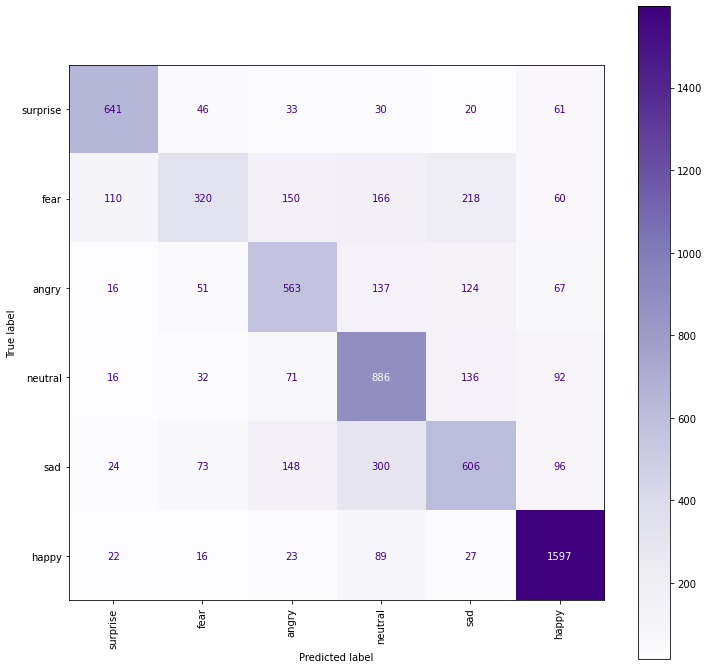

In [21]:
cm= confusion_matrix(true_predictions,model_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=used_classes)

fig, ax = plt.subplots(figsize=(12, 12))
display = display.plot(xticks_rotation='vertical', ax=ax,cmap='Purples')

plt.show()

In [22]:
emotion_map  = test_images.class_indices
emotion_map_inv = dict((v,k) for k,v in emotion_map.items())

for i in range(len(cm)):
    print( '{}     \t-> correct: {}  \t total: {} \t % correct: {:.2f}%'
          .format(used_classes[i],
                  cm[i][i],
                  int(test_counts[emotion_map_inv[i]]),
                  cm[i][i]/int(test_counts[emotion_map_inv[i]])*100
                  )
         )

surprise     	-> correct: 641  	 total: 831 	 % correct: 77.14%
fear     	-> correct: 320  	 total: 1024 	 % correct: 31.25%
angry     	-> correct: 563  	 total: 958 	 % correct: 58.77%
neutral     	-> correct: 886  	 total: 1233 	 % correct: 71.86%
sad     	-> correct: 606  	 total: 1247 	 % correct: 48.60%
happy     	-> correct: 1597  	 total: 1774 	 % correct: 90.02%


From these results, it's clear the model struggled with two classes in particular, fear and sad.

For errors in fear images, the majority were misclassified as sad.
For errors in sad images, the majority were misclassified as neutral.

Lets have a look at some of our misclassified images. In this situation, the test image data is stored in a DirectoryIterator object. I could not find an efficient way to reference specific images from this object as they are stored in batches of 64 and the indices don't align. As a quick fix, I wrote an ugly nested for loop to extract the image data from each batch and realign the images in a single array so they can be referenced correctly. The 'misclassified' list defined below contains the indexes of the models errors.

In [23]:
misclassified = [index for index,(i,j) in enumerate(zip(model_predictions, true_predictions)) if  i != j]

In [24]:
test_image_data =  []
for i in range(0,validation_steps):
    test_batch = test_images[i][0]
    for test_im in range(0,test_batch.shape[0]):
        test_image_data.append(test_batch[test_im])
        
test_image_data = np.array(test_image_data)

Now let's have a look at some misclassified images and see if they're justified or not 

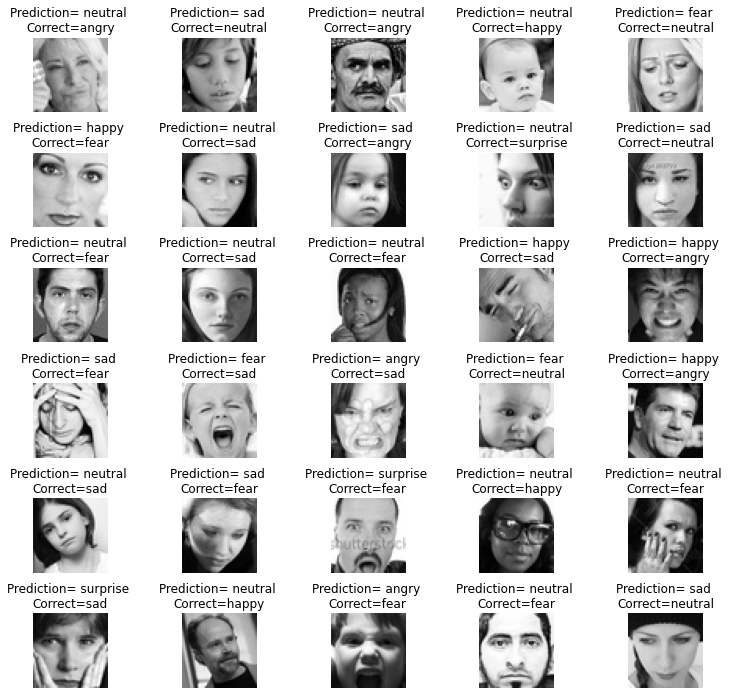

In [25]:
L=6
W=5
mixed_misclassified = random.sample(misclassified, L*W) # take a random sample of misclassified images
fig,axes=plt.subplots(L,W,figsize=(12,12))
axes=axes.ravel()

for index,k in enumerate(mixed_misclassified[0:L*W]):
    axes[index].imshow(test_image_data[k][:, :, 0],cmap='gray')
    axes[index].set_title('Prediction= {} \nCorrect={}'.format(emotion_map_inv[model_predictions[k]],emotion_map_inv[true_predictions[k]]))
    axes[index].axis('off')
    plt.subplots_adjust(wspace=1)
    plt.subplots_adjust(hspace=0.5)

As you can see, there is plenty of misclassified images that seem to just have incorrect labels in the first place. I'm not sure how this dataset was labelled but there is some clear error which explains why human accuracy is only around 65%. Incorrect labels in the training data leads to our model learning invalid features which also adds to the difficulty in classification. So overall, the model accuracy of ~65% is a good performance considering the limitations of the data.

Finally let's have a look at some of the images our model correctly classified.

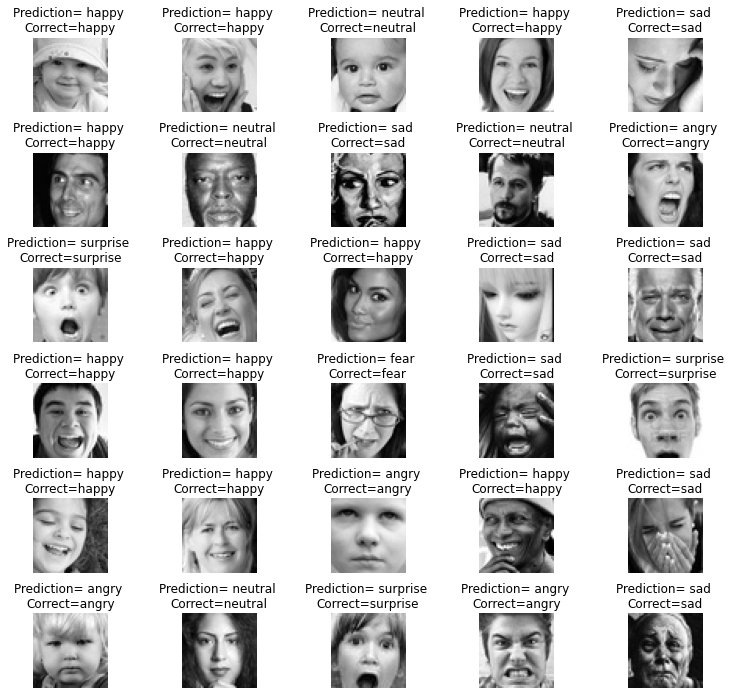

In [29]:
all_image_indices = list(range(len(test_image_data)))
corect_predictions_all = [i for i in all_image_indices if i not in misclassified]
corect_predictions = random.sample(corect_predictions_all, L*W) # take a random sample of misclassified images

fig,axes=plt.subplots(L,W,figsize=(12,12))
axes=axes.ravel()

for index,k in enumerate(corect_predictions[0:L*W]):
    axes[index].imshow(test_image_data[k][:, :, 0],cmap='gray')
    axes[index].set_title('Prediction= {} \nCorrect={}'.format(emotion_map_inv[model_predictions[k]],emotion_map_inv[true_predictions[k]]))
    axes[index].axis('off')
    plt.subplots_adjust(wspace=1)
    plt.subplots_adjust(hspace=0.5)

Next I will look into integrating this model with OpenCV to build some real time emotion detection systems.